In [1]:
import pandas as pd
import os

In [ ]:
!pip install -U scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 16.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [ ]:
!pip install -U kaleido

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.3 MB/s eta 0:00:00


### Loading the dataset

In [2]:
from google.colab import drive
drive.mount('/gdrive')

project_folder = '/gdrive/MyDrive/ProjectTCNER'
data_folder = os.path.join(project_folder, "data")
trainset_file = os.path.join(data_folder, "DBLPTrainset.txt")
testset_file = os.path.join(data_folder, "DBLPTestset.txt")
ground_truth_file = os.path.join(data_folder, "DBLPTestGroundTruth.txt")

out_folder = os.path.join(project_folder, "out")
SEED = 46532

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [3]:
dataset_train = pd.read_table(os.path.join(trainset_file), sep="\t", header=None, names=['y', 'X'],
                              index_col=0)

In [4]:
X_train = dataset_train['X']
y_train = dataset_train['y']

In [5]:
# Test set
y_test = pd.read_table(os.path.join(ground_truth_file), sep="\t", header=None, names=['y'],
                              index_col=0)['y']
X_test = pd.read_table(os.path.join(testset_file), sep="\t", header=None, names=['X'],
                       index_col=0)['X']

# Utilities

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import ComplementNB
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC

from nltk import word_tokenize
from nltk.stem import SnowballStemmer, PorterStemmer, LancasterStemmer
import nltk
from nltk.corpus import stopwords

import numpy as np
import json

In [7]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [8]:
def compute_scores(y_true, y_pred):
  # Confusion matrix
  cm = metrics.confusion_matrix(y_true, y_pred)
  # Accuracy
  acc = metrics.accuracy_score(y_true, y_pred)
  # Balanced accuracy
  bal_acc = metrics.balanced_accuracy_score(y_true, y_pred)
  # precision
  m_prec = metrics.precision_score(y_true, y_pred, average='micro')
  # recall
  m_rec = metrics.recall_score(y_true, y_pred, average='micro')
  # f1
  m_f1 = metrics.f1_score(y_true, y_pred, average='micro')
  return dict(confusion_matrix=cm, accuracy=acc, bal_accuracy=bal_acc, precision_m=m_prec, recall_m=m_rec, f1_m=m_f1)

In [9]:
scoring = ['accuracy', 'balanced_accuracy', 'precision_micro', 'recall_micro', 'f1_micro']

In [10]:
def hyperparameter_search(pipeline, param_grid,
                            X_train, y_train,
                            search_type=GridSearchCV, *args, **kwargs):
  search = search_type(pipeline, param_grid, *args, **kwargs)
  search.fit(X_train, y_train)
  return search

In [11]:
def cross_validate_refit(model,
                         X_train, y_train,
                         X_test, y_test,
                         cv=StratifiedKFold(n_splits=5, random_state=SEED, shuffle=True),
                         scoring=scoring,
                         result_files={
                             'cv': None,
                             'eval': None
                         },
                         *args, **kwargs):
  results = cross_validate(model, X_train, y_train,
                           cv=cv,
                           scoring=scoring,
                           return_train_score=True,
                           *args, **kwargs)
  results_df = pd.DataFrame.from_dict(results)
  if result_files.get('cv', None):
    results_df.to_csv(result_files['cv'], index=False)
    print(f'Cross validation results saved to {result_files.get("cv")}')
  # Refit whole model
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  scores = compute_scores(y_test, y_pred)
  if result_files.get('eval', None):
    with open(result_files['eval'], 'w') as jfile:
      scores['confusion_matrix'] = scores['confusion_matrix'].tolist()
      scores['y_pred'] = y_pred.tolist()
      jfile.write(json.dumps(scores))
    print(f'Evaluation scores saved to {result_files.get("eval")}')
  return results_df, scores

# Naive Bayes

In [12]:
tfidf_vect = TfidfVectorizer(
    stop_words=stop_words, lowercase=True, ngram_range=(1, 2))

In [13]:
tfidf_vect.fit(X_train)

TfidfVectorizer(ngram_range=(1, 2),
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...])

In [14]:
X_train_tfidf = tfidf_vect.transform(X_train)

In [15]:
X_test_tfidf = tfidf_vect.transform(X_test)

In [ ]:
comp_NB = ComplementNB()

In [ ]:
results = cross_validate(comp_NB, X_train_tfidf, y_train,
                         cv=StratifiedKFold(n_splits=5, random_state=SEED, shuffle=True),
                         scoring=scoring, return_train_score=True)

In [ ]:
results_NB_df = pd.DataFrame.from_dict(results)
results_NB_df

,fit_time,score_time,test_accuracy,train_accuracy,test_balanced_accuracy,train_balanced_accuracy,test_precision_micro,train_precision_micro,test_recall_micro,train_recall_micro,test_f1_micro,train_f1_micro
0,0.563854,0.310791,0.867637,0.979785,0.848215,0.978141,0.867637,0.979785,0.867637,0.979785,0.867637,0.979785
1,0.176717,0.339813,0.871564,0.980074,0.853587,0.978298,0.871564,0.980074,0.871564,0.980074,0.871564,0.980074
2,0.261940,0.212566,0.879649,0.979092,0.863505,0.977373,0.879649,0.979092,0.879649,0.979092,0.879649,0.979092
3,0.354617,0.276603,0.873152,0.979382,0.858663,0.977588,0.873152,0.979382,0.873152,0.979382,0.873152,0.979382
4,0.192391,0.331623,0.875462,0.979151,0.860748,0.977018,0.875462,0.979151,0.875462,0.979151,0.875462,0.979151


In [ ]:
results_NB_df.to_csv(os.path.join(out_folder, 'NB_TFIDF.5_fold_cv_results.csv'), index=False)

In [ ]:
# Refit on whole train set
comp_NB.fit(X_train_tfidf, y_train)

ComplementNB()

In [ ]:
comp_nb_tfidif_pred = comp_NB.predict(X_test_tfidf)

In [ ]:
comp_nb_tfidif_metrics = compute_scores(y_test, comp_nb_tfidif_pred)
comp_nb_tfidif_metrics

{'confusion_matrix': array([[ 401,   38,    7,   24,   32],
        [  56, 1939,   16,   27,    5],
        [   4,   30,  142,    6,    4],
        [  18,   10,    2,  157,   32],
        [  24,   16,    1,   42,  340]]),
 'accuracy': 0.8831900385413578,
 'bal_accuracy': 0.8064035186177841,
 'precision_m': 0.8831900385413578,
 'recall_m': 0.8831900385413578,
 'f1_m': 0.8831900385413578}

In [ ]:
with open(os.path.join(out_folder, 'NB_TFIDF.results.json'), 'w') as jfile:
  comp_nb_tfidif_metrics['confusion_matrix'] = comp_nb_tfidif_metrics['confusion_matrix'].tolist()
  comp_nb_tfidif_metrics['y_pred'] = comp_nb_tfidif_pred.tolist()
  jfile.write(json.dumps(comp_nb_tfidif_metrics))

## Experimenting and refining

In [ ]:
grid_search = hyperparameter_search(
    pipeline=Pipeline([
      ('tfidf', TfidfVectorizer()),
      ('nb', ComplementNB())
    ]),
    param_grid={
      'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2), (1, 3), (2, 3), (3, 3)],
      'tfidf__min_df': [1, 3, 5],
      'tfidf__max_df': [1.0, 0.95, 0.90],
      'tfidf__stop_words': [None, stop_words, 'english']
    },
    X_train=X_train, y_train=y_train,
    cv=StratifiedKFold(n_splits=5, random_state=SEED, shuffle=True),
    scoring='f1_micro', n_jobs=-1, verbose=1
)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


In [ ]:
print("Best configuration found:")
print(grid_search.best_params_)
print(f"Best score: {grid_search.best_score_}")

Best configuration found:
{'tfidf__max_df': 1.0, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'b

Does stemming impact?

In [ ]:
class CustomTokenizer():
  def __init__(self, stemmer):
    self.stemmer = stemmer

  def __call__(self, doc):
    tokens = word_tokenize(doc)
    step1 = [w for w in tokens if w not in stop_words]
    step2 = [self.stemmer.stem(t) for t in step1]
    return step2

In [ ]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(lowercase=True, ngram_range=(1, 2))),
    ('nb', ComplementNB())
])

params = {
    'tfidf__tokenizer': [
        CustomTokenizer(SnowballStemmer(language='english')),
        CustomTokenizer(PorterStemmer()),
        CustomTokenizer(LancasterStemmer())],
}

In [ ]:
grid_search = GridSearchCV(pipeline, params,
                           cv=StratifiedKFold(n_splits=5, random_state=SEED, shuffle=True),
                           scoring='f1_micro', n_jobs=-1, verbose=1)

In [ ]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=46532, shuffle=True),
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(ngram_range=(1, 2))),
                                       ('nb', ComplementNB())]),
             n_jobs=-1,
             param_grid={'tfidf__tokenizer': [<__main__.CustomTokenizer object at 0x7ceeff9b7a60>,
                                              <__main__.CustomTokenizer object at 0x7cef0ae703a0>,
                                              <__main__.CustomTokenizer object at 0x7cef0ae71480>]},
             scoring='f1_micro', verbose=1)

In [ ]:
print("Best configuration found:")
print(grid_search.best_params_)
print(f"Best score: {grid_search.best_score_}")

Best configuration found:
{'tfidf__tokenizer': <__main__.CustomTokenizer object at 0x7cef0ae703a0>}
Best score: 0.862958152237265


Other vectorizer

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
grid_search = hyperparameter_search(
    pipeline=Pipeline([
      ('count', CountVectorizer()),
      ('nb', ComplementNB())
    ]),
    param_grid={
      'count__ngram_range': [(1, 1), (1, 2), (2, 2), (1, 3), (2, 3), (3, 3)],
      'count__min_df': [1, 3, 5],
      'count__max_df': [1.0, 0.95, 0.90],
      'count__stop_words': [None, stop_words, 'english']
    },
    X_train=X_train, y_train=y_train,
    cv=StratifiedKFold(n_splits=5, random_state=SEED, shuffle=True),
    scoring='f1_micro', n_jobs=-1, verbose=2
)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


In [ ]:
print("Best configuration found:")
print(grid_search.best_params_)
print(f"Best score: {grid_search.best_score_}")

Best configuration found:
{'count__max_df': 1.0, 'count__min_df': 1, 'count__ngram_range': (1, 2), 'count__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'b

# k-NN

In [17]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
grid_search = hyperparameter_search(
    pipeline=Pipeline([
      ('tfidf', TfidfVectorizer(lowercase=True, stop_words=stop_words)),
      ('knn', KNeighborsClassifier(n_jobs=-1))
    ]),
    param_grid={
      'tfidf__ngram_range': [(1, 2), (2, 2)],
      'tfidf__min_df': [1, 3, 5],
      'tfidf__max_df': [1.0, 0.95, 0.90],
      'knn__n_neighbors': [3, 5, 7, 11],
      'knn__metric': ['euclidean', 'cosine'],
      'knn__weights': ['uniform', 'distance']
    },
    X_train=X_train, y_train=y_train,
    cv=StratifiedKFold(n_splits=5, random_state=SEED, shuffle=True),
    scoring='f1_micro', n_jobs=-1, verbose=1
)

In [ ]:
print("Best configuration found:")
print(grid_search.best_params_)
print(f"Best score: {grid_search.best_score_}")

Best configuration found:
{'knn__metric': 'cosine', 'knn__n_neighbors': 11, 'knn__weights': 'distance', 'tfidf__max_df': 1.0, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2)}
Best score: 0.8288128594967781


In [ ]:
knn_class = KNeighborsClassifier(n_neighbors=11, metric='cosine', weights='distance')

In [ ]:
results = cross_validate(knn_class, X_train_tfidf, y_train,
                         cv=StratifiedKFold(n_splits=5, random_state=SEED, shuffle=True),
                         scoring=scoring,return_train_score=True)

In [ ]:
results_knn_df = pd.DataFrame.from_dict(results)
results_knn_df

,fit_time,score_time,test_accuracy,train_accuracy,test_balanced_accuracy,train_balanced_accuracy,test_precision_micro,train_precision_micro,test_recall_micro,train_recall_micro,test_f1_micro,train_f1_micro
0,0.115307,7.587667,0.825133,0.999884,0.798359,0.999848,0.825133,0.999884,0.825133,0.999884,0.825133,0.999884
1,0.022368,2.156154,0.829984,0.999942,0.804230,0.999924,0.829984,0.999942,0.829984,0.999942,0.829984,0.999942
2,0.021080,1.877680,0.840148,0.999884,0.817836,0.999848,0.840148,0.999884,0.840148,0.999884,0.840148,0.999884
3,0.039274,1.939363,0.827634,0.999942,0.802767,0.999924,0.827634,0.999942,0.827634,0.999942,0.827634,0.999942
4,0.020954,2.272516,0.824630,1.000000,0.801591,1.000000,0.824630,1.000000,0.824630,1.000000,0.824630,1.000000


In [ ]:
results_knn_df.to_csv(os.path.join(out_folder, 'KNN_TFIDF.5_fold_cv_results.csv'), index=False)

In [ ]:
# Refit on whole train set
knn_class.fit(X_train_tfidf, y_train)

KNeighborsClassifier(metric='cosine', n_neighbors=11, weights='distance')

In [ ]:
knn_tfidif_pred = knn_class.predict(X_test_tfidf)

In [ ]:
knn_tfidif_metrics = compute_scores(y_test, knn_tfidif_pred)
knn_tfidif_metrics

{'confusion_matrix': array([[ 371,   29,    8,   40,   54],
        [  83, 1811,   46,   83,   20],
        [   9,   23,  128,   13,   13],
        [  15,    6,    4,  161,   33],
        [  29,   17,   12,   62,  303]]),
 'accuracy': 0.8224132819448562,
 'bal_accuracy': 0.7530258498776035,
 'precision_m': 0.8224132819448562,
 'recall_m': 0.8224132819448562,
 'f1_m': 0.8224132819448562}

In [ ]:
with open(os.path.join(out_folder, 'KNN_TFIDF.results.json'), 'w') as jfile:
  knn_tfidif_metrics['confusion_matrix'] = knn_tfidif_metrics['confusion_matrix'].tolist()
  knn_tfidif_metrics['y_pred'] = knn_tfidif_pred.tolist()
  jfile.write(json.dumps(knn_tfidif_metrics))

# SVM

In [ ]:
grid_search = hyperparameter_search(
    pipeline=Pipeline([
      ('tfidf', TfidfVectorizer(lowercase=True, stop_words=stop_words, ngram_range=(1, 2))),
      ('svm', SVC(class_weight='balanced', random_state=SEED))
    ]),
    param_grid={
      'svm__kernel': ['rbf', 'linear'],
      'svm__C': [0.1, 1, 10],
      'svm__gamma': ['auto', 'scale']
    },
    X_train=X_train, y_train=y_train,
    cv=StratifiedKFold(n_splits=5, random_state=SEED, shuffle=True),
    scoring='f1_micro', n_jobs=-1, verbose=1
)

In [ ]:
print("Best configuration found:")
print(grid_search.best_params_)
print(f"Best score: {grid_search.best_score_}")

Best configuration found:
{'svm__C': 1, 'svm__gamma': 'auto', 'svm__kernel': 'linear'}
Best score: 0.871782905470521


In [ ]:
svm_class = SVC(class_weight='balanced', random_state=SEED,
                C=1, gamma='auto', kernel='linear')

In [ ]:
results = cross_validate(svm_class, X_train_tfidf, y_train,
                         cv=StratifiedKFold(n_splits=5, random_state=SEED, shuffle=True),
                         scoring=scoring, return_train_score=True)

In [ ]:
results_svm_df = pd.DataFrame.from_dict(results)
results_svm_df

,fit_time,score_time,test_accuracy,train_accuracy,test_balanced_accuracy,train_balanced_accuracy,test_precision_micro,train_precision_micro,test_recall_micro,train_recall_micro,test_f1_micro,train_f1_micro
0,70.728980,8.142141,0.864172,0.987640,0.847001,0.989258,0.864172,0.987640,0.864172,0.987640,0.864172,0.987640
1,46.871079,5.839575,0.869485,0.988160,0.851783,0.989723,0.869485,0.988160,0.869485,0.988160,0.869485,0.988160
2,46.463718,6.474169,0.878725,0.987582,0.863572,0.989268,0.878725,0.987582,0.878725,0.987582,0.878725,0.987582
3,48.923869,6.411645,0.875693,0.986370,0.862556,0.988372,0.875693,0.986370,0.875693,0.986370,0.875693,0.986370
4,46.655641,5.836663,0.868299,0.987872,0.853652,0.989625,0.868299,0.987872,0.868299,0.987872,0.868299,0.987872


In [ ]:
results_svm_df.to_csv(os.path.join(out_folder, 'SVM_TFIDF.5_fold_cv_results.csv'), index=False)

In [ ]:
# Refit on whole train set
svm_class.fit(X_train_tfidf, y_train)

SVC(C=1, class_weight='balanced', gamma='auto', kernel='linear',
    random_state=46532)

In [ ]:
svm_tfidif_pred = svm_class.predict(X_test_tfidf)

In [ ]:
svm_tfidif_metrics = compute_scores(y_test, svm_tfidif_pred)
svm_tfidif_metrics

{'confusion_matrix': array([[ 401,   30,    7,   33,   31],
        [  85, 1884,   26,   37,   11],
        [   0,   19,  155,    8,    4],
        [   9,    5,    5,  172,   28],
        [  28,   13,   10,   50,  322]]),
 'accuracy': 0.8698487992884673,
 'bal_accuracy': 0.8201857662161387,
 'precision_m': 0.8698487992884673,
 'recall_m': 0.8698487992884673,
 'f1_m': 0.8698487992884673}

In [ ]:
with open(os.path.join(out_folder, 'SVM_TFIDF.results.json'), 'w') as jfile:
  svm_tfidif_metrics['confusion_matrix'] = svm_tfidif_metrics['confusion_matrix'].tolist()
  svm_tfidif_metrics['y_pred'] = svm_tfidif_pred.tolist()
  jfile.write(json.dumps(svm_tfidif_metrics))

# Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
random_search = hyperparameter_search(
    pipeline=Pipeline([
      ('tfidf', TfidfVectorizer(lowercase=True, stop_words=stop_words, ngram_range=(1, 2))),
      ('rf', RandomForestClassifier(n_jobs=-1, random_state=SEED))
    ]),
    param_grid={
      'rf__n_estimators': [50, 100, 150, 200, 300],
      'rf__criterion': ['gini', 'entropy'],
      'rf__max_features': ['sqrt', 'log2', None],
      'rf__max_depth': [None, 10, 20, 30],
      'rf__min_samples_split': [2, 5, 10],
      'rf__min_samples_leaf': [1, 2, 4],
      'rf__bootstrap': [True, False],
      'rf__class_weight': ['balanced', 'balanced_subsample'],
      'rf__ccp_alpha': [0.0, 0.05, 0.10]
    },
    X_train=X_train, y_train=y_train,
    search_type=RandomizedSearchCV,
    n_iter=10,
    cv=StratifiedKFold(n_splits=5, random_state=SEED, shuffle=True),
    scoring='f1_micro', n_jobs=-1, verbose=1, refit=False,
    random_state=SEED
)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [ ]:
print("Best configuration found (out of 10 trials):")
print(random_search.best_params_)
print(f"Best score: {random_search.best_score_}")

Best configuration found (out of 10 trials):
{'rf__n_estimators': 300, 'rf__min_samples_split': 10, 'rf__min_samples_leaf': 1, 'rf__max_features': 'sqrt', 'rf__max_depth': None, 'rf__criterion': 'entropy', 'rf__class_weight': 'balanced_subsample', 'rf__ccp_alpha': 0.0, 'rf__bootstrap': False}
Best score: 0.8318624681840948


In [ ]:
rf_cv_results, rf_eval_scores = cross_validate_refit(
    model=RandomForestClassifier(n_estimators=300, min_samples_split=10,
                       min_samples_leaf=1, max_features='sqrt',
                       max_depth=None, criterion='entropy',
                       class_weight='balanced_subsample',
                       ccp_alpha=0.0, bootstrap=False),
    X_train=X_train_tfidf, y_train=y_train,
    X_test=X_test_tfidf, y_test=y_test,
    result_files={
        'cv': os.path.join(out_folder, 'RF_TFIDF.5_fold_cv_results.csv'),
        'eval': os.path.join(out_folder, 'RF_TFIDF.results.json')
    }
)

Cross validation results saved to /gdrive/MyDrive/ProjectTCNER/out/RF_TFIDF.5_fold_cv_results.csv
Evaluation scores saved to /gdrive/MyDrive/ProjectTCNER/out/RF_TFIDF.results.json


In [ ]:
rf_cv_results

,fit_time,score_time,test_accuracy,train_accuracy,test_balanced_accuracy,train_balanced_accuracy,test_precision_micro,train_precision_micro,test_recall_micro,train_recall_micro,test_f1_micro,train_f1_micro
0,952.703576,2.105158,0.833218,0.999653,0.817735,0.999631,0.833218,0.999653,0.833218,0.999653,0.833218,0.999653
1,870.757673,2.189066,0.835528,0.999827,0.820631,0.999820,0.835528,0.999827,0.835528,0.999827,0.835528,0.999827
2,893.885338,2.264145,0.844075,0.999827,0.830047,0.999808,0.844075,0.999827,0.844075,0.999827,0.844075,0.999827
3,861.566758,2.226270,0.836414,0.999769,0.822473,0.999767,0.836414,0.999769,0.836414,0.999769,0.836414,0.999769
4,861.807460,2.085964,0.835490,0.999942,0.823833,0.999944,0.835490,0.999942,0.835490,0.999942,0.835490,0.999942


In [ ]:
rf_eval_scores

{'confusion_matrix': [[354, 36, 20, 48, 44],
  [96, 1734, 112, 73, 28],
  [2, 15, 157, 9, 3],
  [8, 5, 13, 162, 31],
  [23, 15, 30, 57, 298]],
 'accuracy': 0.801956715090424,
 'bal_accuracy': 0.7684469786150921,
 'precision_m': 0.801956715090424,
 'recall_m': 0.801956715090424,
 'f1_m': 0.801956715090424,
 'y_pred': ['ISCAS',
  'VLDB',
  'ISCAS',
  'INFOCOM',
  'SIGGRAPH',
  'ISCAS',
  'ISCAS',
  'ISCAS',
  'INFOCOM',
  'INFOCOM',
  'ISCAS',
  'ISCAS',
  'ISCAS',
  'INFOCOM',
  'ISCAS',
  'WWW',
  'ISCAS',
  'ISCAS',
  'INFOCOM',
  'ISCAS',
  'INFOCOM',
  'WWW',
  'INFOCOM',
  'ISCAS',
  'ISCAS',
  'ISCAS',
  'WWW',
  'INFOCOM',
  'VLDB',
  'ISCAS',
  'VLDB',
  'VLDB',
  'ISCAS',
  'ISCAS',
  'ISCAS',
  'ISCAS',
  'ISCAS',
  'SIGGRAPH',
  'ISCAS',
  'WWW',
  'WWW',
  'INFOCOM',
  'INFOCOM',
  'INFOCOM',
  'VLDB',
  'ISCAS',
  'VLDB',
  'INFOCOM',
  'ISCAS',
  'ISCAS',
  'ISCAS',
  'ISCAS',
  'INFOCOM',
  'SIGGRAPH',
  'WWW',
  'ISCAS',
  'ISCAS',
  'VLDB',
  'ISCAS',
  'VLDB',
  'ISCAS

# Testing word embeddings

In [19]:
import numpy as np
import re

In [ ]:
!curl -o '/content/glove_embeddings.zip' 'https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  822M  100  822M    0     0  5287k      0  0:02:39  0:02:39 --:--:-- 5112k


In [ ]:
!unzip '/content/glove_embeddings.zip'

Archive:  /content/glove_embeddings.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
def load_glove_embeddings(path):
    embeddings_dict = {}
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.split()
            word = parts[0]
            vector = np.array(parts[1:], dtype=np.float32)
            embeddings_dict[word] = vector
    return embeddings_dict

In [ ]:
def preprocess_text(text):
    text = text.lower()  # convert to lowercase
    text = re.sub(r'\d+', '', text)  # remove numbers
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra spaces
    return text

In [ ]:
embeddings_index = load_glove_embeddings('glove.6B.100d.txt')

In [ ]:
X_train_preprocessed = [preprocess_text(doc) for doc in X_train]
X_test_preprocessed = [preprocess_text(doc) for doc in X_test]

In [ ]:
def document_vector(doc, embeddings_index):
    words = doc.split()
    valid_words = [word for word in words if word in embeddings_index]
    if not valid_words:
        return np.zeros(100)  # Return a zero vector if no valid words are found
    word_vectors = [embeddings_index[word] for word in valid_words]
    return np.mean(word_vectors, axis=0)

X_train_vect = np.array([document_vector(doc, embeddings_index) for doc in X_train_preprocessed])
X_test_vect = np.array([document_vector(doc, embeddings_index) for doc in X_test_preprocessed])

## SVM

In [ ]:
grid_search = hyperparameter_search(
    pipeline=Pipeline([
      ('svm', SVC(class_weight='balanced', random_state=SEED))
    ]),
    param_grid={
      'svm__kernel': ['rbf', 'linear'],
      'svm__C': [0.1, 1, 10],
      'svm__gamma': ['auto', 'scale']
    },
    X_train=X_train_vect, y_train=y_train,
    cv=StratifiedKFold(n_splits=5, random_state=SEED, shuffle=True),
    scoring='f1_micro', n_jobs=-1, verbose=1
)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [ ]:
print("Best configuration found:")
print(grid_search.best_params_)
print(f"Best score: {grid_search.best_score_}")

Best configuration found:
{'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
Best score: 0.7527145516054944


# Plots

In [20]:
import plotly.express as px

In [ ]:
# NB results
nb_cv_res = pd.read_csv(os.path.join(out_folder, "NB_TFIDF.5_fold_cv_results.csv"))
nb_cv_res['model'] = "Complement Naive Bayes"
nb_cv_res['fold'] = nb_cv_res.index
nb_cv_res = nb_cv_res.melt(id_vars=['model', 'fold'], var_name='metric', value_name='value')
with open(os.path.join(out_folder, "NB_TFIDF.results.json")) as res_file:
  nb_eval_res = json.load(res_file)

In [ ]:
# kNN results
knn_cv_res = pd.read_csv(os.path.join(out_folder, "KNN_TFIDF.5_fold_cv_results.csv"))
knn_cv_res['model'] = "K-Nearest Neighbors"
knn_cv_res['fold'] = knn_cv_res.index
knn_cv_res = knn_cv_res.melt(id_vars=['model', 'fold'], var_name='metric', value_name='value')
with open(os.path.join(out_folder, "KNN_TFIDF.results.json")) as res_file:
  knn_eval_res = json.load(res_file)

In [ ]:
# SVM results
svm_cv_res = pd.read_csv(os.path.join(out_folder, "SVM_TFIDF.5_fold_cv_results.csv"))
svm_cv_res['model'] = "SVM"
svm_cv_res['fold'] = svm_cv_res.index
svm_cv_res = svm_cv_res.melt(id_vars=['model', 'fold'], var_name='metric', value_name='value')
with open(os.path.join(out_folder, "SVM_TFIDF.results.json")) as res_file:
  svm_eval_res = json.load(res_file)

In [ ]:
# RF results
rf_cv_res = pd.read_csv(os.path.join(out_folder, "RF_TFIDF.5_fold_cv_results.csv"))
rf_cv_res['model'] = "Random Forest"
rf_cv_res['fold'] = rf_cv_res.index
rf_cv_res = rf_cv_res.melt(id_vars=['model', 'fold'], var_name='metric', value_name='value')
with open(os.path.join(out_folder, "RF_TFIDF.results.json")) as res_file:
  rf_eval_res = json.load(res_file)

In [ ]:
all_cv_res = pd.concat([nb_cv_res, knn_cv_res, svm_cv_res, rf_cv_res])
all_eval_res = {
    'nb': nb_eval_res,
    'knn': knn_eval_res,
    'svm': svm_eval_res,
    'rf': rf_eval_res
}

In [ ]:
metrics_of_interest=[
    'precision_micro',
    'recall_micro',
    'f1_micro',
    'balanced_accuracy'
]

In [ ]:
px.line(all_cv_res.loc[all_cv_res['metric'].isin(["test_" + m for m in metrics_of_interest])],
        x='fold', y='value', facet_col='metric', color='model')

In [21]:
from sklearn.model_selection import learning_curve

results = {}
models = {
    'nb': ComplementNB(),
    'knn': KNeighborsClassifier(n_neighbors=11, metric='cosine', weights='distance'),
    'svm': SVC(class_weight='balanced', random_state=SEED,
                C=1, gamma='auto', kernel='linear'),
    'rf': RandomForestClassifier(n_estimators=300, min_samples_split=10,
                       min_samples_leaf=1, max_features='sqrt',
                       max_depth=None, criterion='entropy',
                       class_weight='balanced_subsample',
                       ccp_alpha=0.0, bootstrap=False)
}

# for i, model in models.items():
#   res = learning_curve(
#       model, X_train_tfidf, y_train,
#       train_sizes=np.linspace(0.1, 1.0, 10),
#       cv=StratifiedKFold(n_splits=5, random_state=SEED, shuffle=True),
#       scoring='f1_micro',
#       random_state=SEED,
#       verbose=2,
#       n_jobs=-1
#   )
#   results[i] = res

# results['nb'] = learning_curve(
#       models['nb'], X_train_tfidf, y_train,
#       train_sizes=np.linspace(0.1, 1.0, 10),
#       cv=StratifiedKFold(n_splits=5, random_state=SEED, shuffle=True),
#       scoring='f1_micro',
#       random_state=SEED,
#       verbose=2,
#       n_jobs=-1
#   )

# results['knn'] = learning_curve(
#       models['knn'], X_train_tfidf, y_train,
#       train_sizes=np.linspace(0.1, 1.0, 10),
#       cv=StratifiedKFold(n_splits=5, random_state=SEED, shuffle=True),
#       scoring='f1_micro',
#       random_state=SEED,
#       verbose=2,
#       n_jobs=-1
#   )


In [ ]:
results['svm'] = learning_curve(
      models['svm'], X_train_tfidf, y_train,
      train_sizes=np.linspace(0.1, 1.0, 10),
      cv=StratifiedKFold(n_splits=5, random_state=SEED, shuffle=True),
      scoring='f1_micro',
      random_state=SEED,
      verbose=2,
      n_jobs=-1
  )

[learning_curve] Training set sizes: [ 1731  3462  5194  6925  8657 10388 12119 13851 15582 17314]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  50 | elapsed: 15.3min remaining: 15.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 34.2min finished


In [ ]:
results['rf'] = learning_curve(
      models['rf'], X_train_tfidf, y_train,
      train_sizes=np.linspace(0.1, 1.0, 10),
      cv=StratifiedKFold(n_splits=5, random_state=SEED, shuffle=True),
      scoring='f1_micro',
      random_state=SEED,
      verbose=2,
      n_jobs=-1
  )

In [92]:
from sklearn.model_selection import LearningCurveDisplay

lc_displays = {}
for key, lc in results.items():
  train_sizes, train_scores, test_scores = lc
  lc_displays[key] = LearningCurveDisplay(train_sizes=train_sizes,
                                          train_scores=train_scores,
                                          test_scores=test_scores,
                                          score_name="F1 Score")

KeyError: 'nb'

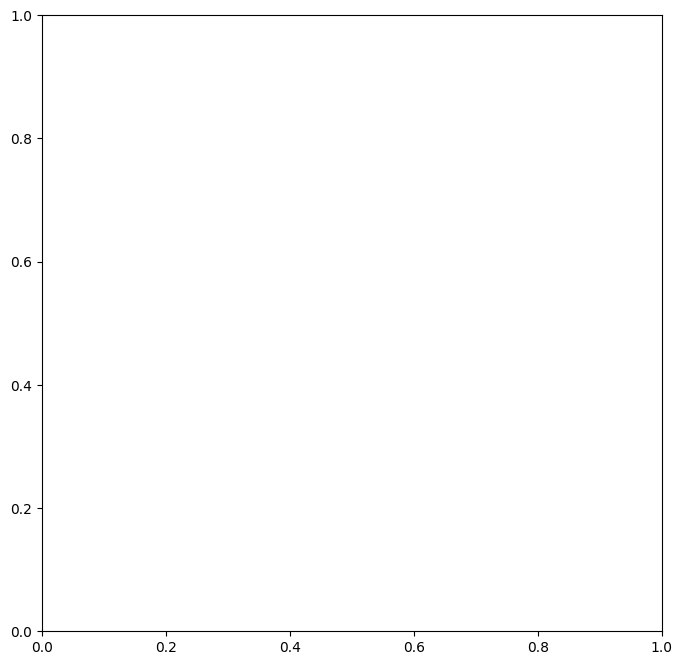

In [94]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))
lc_displays['nb'].plot(ax=ax)
plt.show()

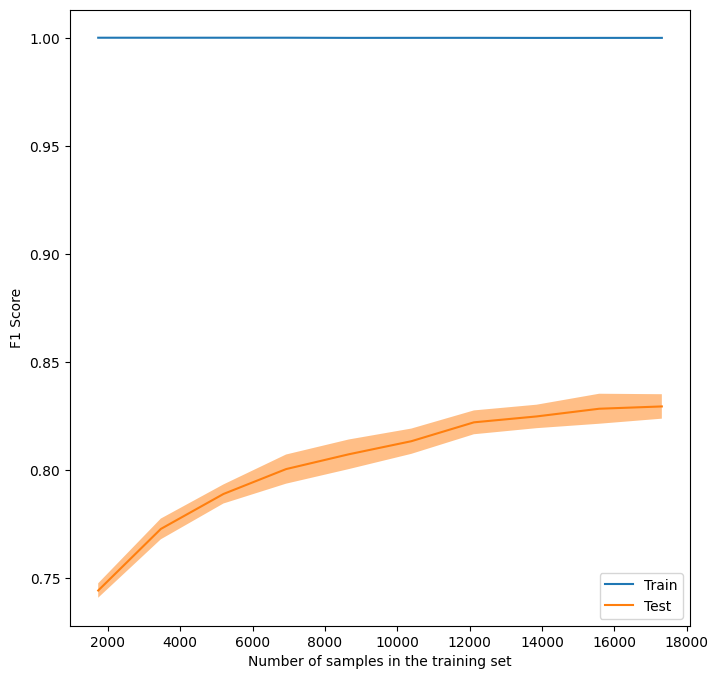

In [95]:
fig, ax = plt.subplots(figsize=(8, 8))
lc_displays['knn'].plot(ax=ax)
plt.show()

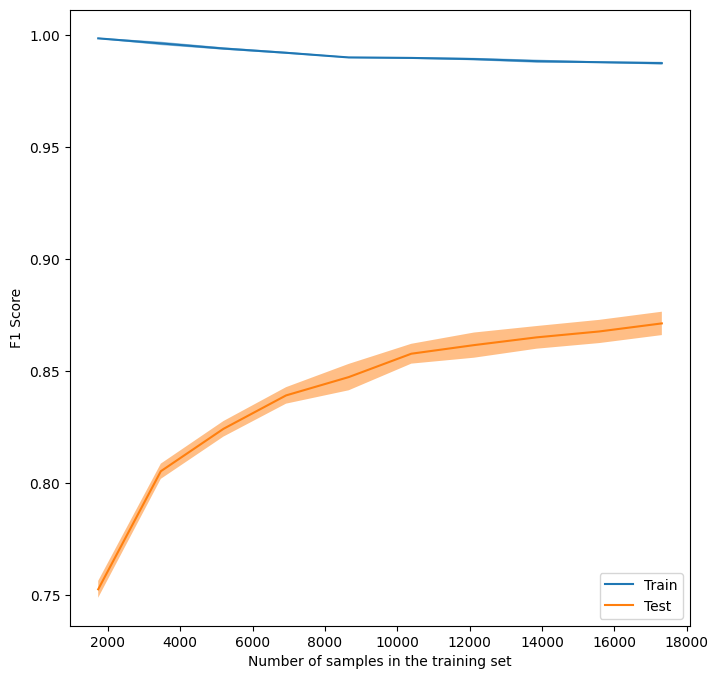

In [97]:
fig, ax = plt.subplots(figsize=(8, 8))
lc_displays['svm'].plot(ax=ax)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(9, 9))
lc_displays['rf'].plot(ax=ax)
plt.show()

In [ ]:
mod_all_cv_res = all_cv_res.copy()
metrics_to_plot = ["test_" + m for m in metrics_of_interest]
metrics_to_plot.extend(["train_" + m for m in metrics_of_interest])
mod_all_cv_res = mod_all_cv_res.loc[mod_all_cv_res['metric'].isin(metrics_to_plot)]
mod_all_cv_res[['phase', 'metric']] = mod_all_cv_res['metric'].str.split('_', n=1, expand=True)
mod_all_cv_res = mod_all_cv_res.groupby(['model', 'metric', 'phase']).agg({'value': 'mean'}).reset_index()



In [ ]:
model_comp_plot = px.bar(mod_all_cv_res,
                        x='model',
                        y='value',
                        color='phase',
                        facet_col='metric',
                        barmode='group',
                        template='plotly_white',
                        color_discrete_sequence=px.colors.qualitative.Set2)
model_comp_plot.update_layout(
    title={
        'text': 'Model comparison'.upper(),
        'x': 0.5,
        'font': {
            'size': 30
        }
    },
    font={
        'family': 'Barlow, sans-serif',
        'size': 16
    },
    yaxis_title='',
    xaxis_title='',
    width=600*2,
    height=300*2,
    legend={
        'orientation': 'h',
        'x': 0.5,
        'xanchor': 'center',
        'y': -0.3
    }
)
model_comp_plot.update_yaxes(
    matches=None,
    showticklabels=True
)

model_comp_plot.for_each_yaxis(lambda y: y.update({'title': ''}))
model_comp_plot.for_each_xaxis(lambda y: y.update({'title': ''}))

In [ ]:
model_comp_plot.write_image(file=os.path.join(out_folder, 'model_comparison.jpg'), scale=2)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

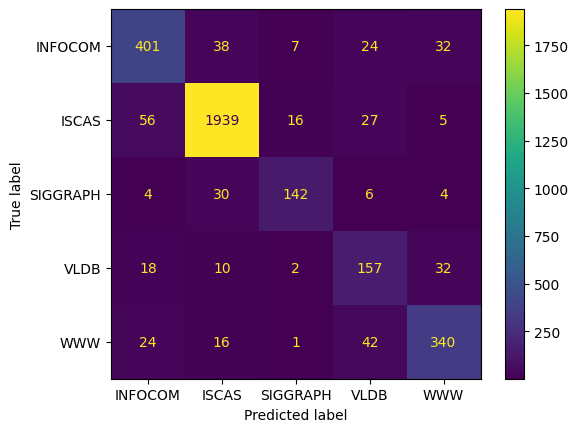

In [ ]:
nb_cm = ConfusionMatrixDisplay.from_predictions(y_test, all_eval_res['nb']['y_pred'])

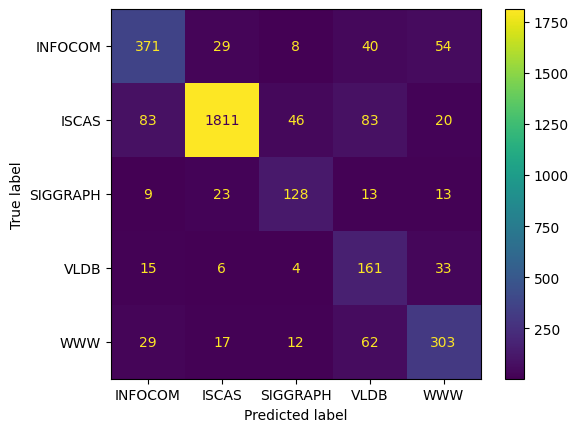

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, all_eval_res['knn']['y_pred'])

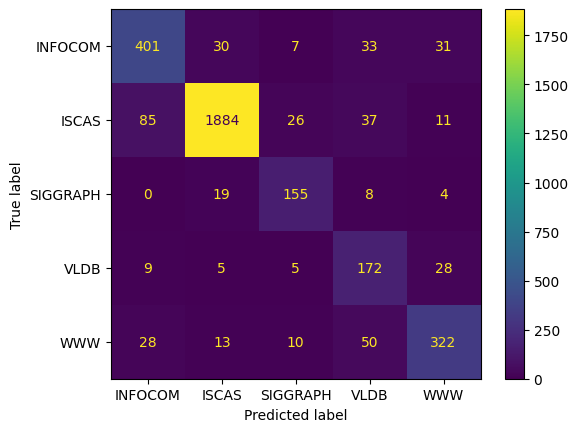

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, all_eval_res['svm']['y_pred'])

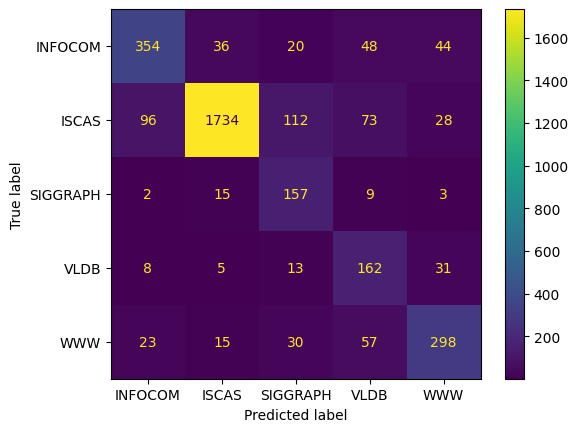

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, all_eval_res['rf']['y_pred'])

In [ ]:
from string import punctuation
from collections import Counter
from collections import defaultdict

counts_per_class = defaultdict(Counter)

for _, row in dataset_train.iterrows():
  title = row['X']
  label = row['y']
  tokens = word_tokenize(title.lower())
  tokens = [t for t in tokens if t not in stop_words]
  tokens = [t for t in tokens if t not in punctuation]
  counts_per_class[label].update(tokens)

In [ ]:
df_counts_per_class = []

for key, val in counts_per_class.items():
  most_common_w = val.most_common(10)
  df = pd.DataFrame.from_records(most_common_w, columns=['word', 'count'])
  df['category'] = key
  df_counts_per_class.append(df)

df_counts_per_class = pd.concat(df_counts_per_class)

In [ ]:
df_counts_per_class.sort_values(by='count', inplace=True)

In [ ]:
w_per_cat_plot = px.bar(df_counts_per_class, y='word', x='count',
                        facet_col='category',
                        facet_col_wrap=2,
                        color='category',
                        orientation='h',
                        template='plotly_white')
w_per_cat_plot.update_layout(
    title={
        'text': 'Top 10 most frequent words per category'.upper(),
        'x': 0.5,
        'font': {
            'size': 30
        }
    },
    font={
        'family': 'Barlow, sans-serif',
        'size': 16
    },
    yaxis_title='',
    xaxis_title='',
    width=600*2,
    height=600*2,
    showlegend=False
)
w_per_cat_plot.update_yaxes(
    categoryorder='total ascending',
    matches=None,
    showticklabels=True
)
w_per_cat_plot.update_xaxes(
    showticklabels=True
)
w_per_cat_plot.for_each_yaxis(lambda y: y.update({'title': ''}))

In [ ]:
w_per_cat_plot.write_image(file=os.path.join(out_folder, 'top_10_per_category.jpg'), scale=2)